In [57]:
import sys
import os
import jax
import jaxlib
print(jax.__version__)
print(jaxlib.__version__)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
os.chdir('../scripts/')
import matplotlib.pyplot as plt
import graphics as gr
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from jax_utils import force_1d_parallel, convert_pos_to_index, scatt_reduce
from jaxkan.utils.PIKAN import gradf
from jaxkan.KAN import KAN
import jax.numpy as jnp
from jax_data import SimDataset 
from jax import vmap

import pickle as pkl
from flax import nnx
import optax
import orbax.checkpoint as ocp
%pylab inline

0.4.35
0.4.34
gpu
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_48655/3514446823.py:8: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)
/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['f', 'norm', 'mod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [58]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': False})
#plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})

In [59]:
#####################
# defining network
#####################

models = ['../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage%db/'%stage for stage in range(1,12)]

models_limits = [0.9]
for mod in models:
    with open(mod+'metadata.pkl', 'rb') as f:
        metadata = pkl.load(f)
    models_limits.append(metadata['a_end'])
print(models_limits)

### (2) OUTPUT NAME
loadfilename = models[-1] #"./run/net1d_151124_unsupervised_PDE2_logNd13epoch5090_loss3.30e-04_L4_N512_.pt"
outstr = loadfilename.split('/')
outstr[-1] = 'Results_seq1DNN_'+str(models_limits[0])+'to'+str(models_limits[-1])+'.pdf'
outstr = '/'.join(outstr)
print(loadfilename, outstr)

### MODEL ARCH, based on the last model (all arch should be the same)
checkpointer = ocp.PyTreeCheckpointer()

with open(loadfilename+'metadata.pkl', 'rb') as f:
        metadata = pkl.load(f)

modeldef = metadata['layers']
req_params = {'k': 3, 'G':metadata['grid_size'], 'grid_e':metadata['grid_adaptivity'], 'grid_range':(-0.5, .5)}
layer_type = 'spline'
print("req params are ", req_params)
dnet = KAN(
    layer_dims=modeldef,
    layer_type=layer_type,
    required_parameters=req_params,
    add_bias=True,
    rngs=nnx.Rngs(2)
)

[0.9, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0]
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage11b/ ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage11b/Results_seq1DNN_0.9to23.0.pdf
req params are  {'k': 3, 'G': 16, 'grid_e': 0.05, 'grid_range': (-0.5, 0.5)}


In [60]:
def make_ic_from_previous(checkpointer, model, previous_model, sim_data):
    #replace initial condition
    init_state = nnx.state(model)
    
    previous_model = os.path.abspath(previous_model)
    previous_state = checkpointer.restore(previous_model, item=init_state)
    # Update the model with the loaded state
    nnx.update(model, previous_state)
    pde_qa = jnp.stack([sim_data.ic_q.squeeze(), sim_data.ic_a.squeeze()]).T
    def z(x):
        return model(x)
    z0 = model(pde_qa)
    v0 = gradf(z,1,1)(pde_qa)
    acc0 = gradf(z,1,2)(pde_qa)
    #do not forget to put the initial weights back in the model
    nnx.update(model, init_state)

    return z0.squeeze(), v0.squeeze(), acc0.squeeze()


def load_model_and_outputs(net, model, amin, amax, aprevious=None, previous_model=None, size='largecustom'):
    size = 'adaptdt_seq_custom%.2fto%.2f'%(amin, amax)
    sim_data = SimDataset(n_data_points = 8000*8000, n_pde_a=64, 
                          key=2, size=size)
    
    # Initialize the checkpointer once
    checkpointer = ocp.PyTreeCheckpointer()
    
    reached_origin = (previous_model is None) #True for stage 1, otherwise False
    if not reached_origin:
        parent = '/'.join(previous_model.split('/')[:-1])
    parent_list = []
    parentdata_list = [
        {'previous_model':previous_model, 'a_start':amin, 'a_end':amax}#, 'datakey':datakey}
        ]
    while not reached_origin:
        # this means that parent is not None
        print(parent)
        with open(parent+'/metadata.pkl', 'rb') as f:
            parent_metadata = pkl.load(f)
        parent_list.append(parent)
        parentdata_list.append(parent_metadata)
        reached_origin = (parent_metadata['previous_model'] is None)
        if parent_metadata['previous_model'] is not None: #then we can add it to the list
            print('previous is', parent_metadata['previous_model'])
            parent = '../models/' + parent_metadata['previous_model'].split('/')[-2]
            parentdata_list[-1]['previous_model'] = '../models/' + '/'.join(parent_metadata['previous_model'].split('/')[-2:])
            print(parent)

    print('Parent models:', parent_list)

    # IC initialization. Step 2 : load and add up all previous displacements
    sum_previous_z0 = jnp.zeros_like(sim_data.z0.squeeze())
    for stage in range(len(parentdata_list)-1):
        # In the first stage, we need to load the true z0
        if stage == 0: #then z0 is the zeldovich approx
            size = 'adaptdt_seq_custom%.2fto%.2f'%(parentdata_list[-1-stage]['a_start'], parentdata_list[-1-stage]['a_end'])
            sim_data = SimDataset(n_data_points = 8000*8000, n_pde_a=64, 
                                key=parentdata_list[-1-stage]['datakey'], size=size)
            sum_previous_z0 += sim_data.z0.squeeze()
        size = 'adaptdt_seq_custom%.2fto%.2f'%(parentdata_list[-1-stage-1]['a_start'], parentdata_list[-1-stage-1]['a_end'])
        sim_data = SimDataset(n_data_points = 8000*8000, n_pde_a=64, 
                                key=parentdata_list[-1-stage]['datakey'], size=size)
        # We also need to fetch the initial conditions from the previous model
        z0_ext, v0_ext, acc0_ext = make_ic_from_previous(checkpointer, net, parentdata_list[-1-stage-1]['previous_model'], sim_data)
        print('loaded model %s at time %.2f'%(parentdata_list[-1-stage-1]['previous_model'],parentdata_list[-1-stage-1]['a_start']))
        sum_previous_z0 += z0_ext.squeeze()

    if previous_model is not None:
        size = 'adaptdt_seq_custom%.2fto%.2f'%(amin, amax)
        sim_data = SimDataset(n_data_points = 8000*8000, n_pde_a=64, 
                              key=2, size=size, z0_ext=sum_previous_z0, v0_ext=v0_ext, acc0_ext=acc0_ext)
    skip_t = 1
    final_t = sim_data.a.size//skip_t * skip_t
    
    init_state = nnx.state(net)
    model = os.path.abspath(model)
    opt_state = checkpointer.restore(model, item=init_state)
    # Update the model with the loaded state
    nnx.update(net, opt_state)

    if aprevious is None:
        i_a = [0] + [j for j in range(10, 161, 50)]
    else:
        i_a = [j for j in range(0, 151, 50)]
    real_a = jnp.array([sim_data.a[i] for i in i_a])
    i_q = sim_data.q[::8]
    i_dx0 = sim_data.dx0[::8]

    q_for_net, a_for_net = jnp.meshgrid(i_q,real_a)
    dx0_for_net, _ = jnp.meshgrid(i_dx0,real_a)
    net_shape = q_for_net.shape
    q_for_net = q_for_net.reshape(-1,1)
    dx0_for_net = dx0_for_net.reshape(-1,1)
    a_for_net = a_for_net.reshape(-1,1)

    real_a = jnp.array([sim_data.a[i] for i in i_a])
    pde_qa = jnp.stack([q_for_net.squeeze(), a_for_net.squeeze()]).T
    
    def z(x):
        return dnet(x)

    zpde = dnet(pde_qa)
    zpde_t = gradf(z,1,1)(pde_qa)
    zpde_tt = gradf(z,1,2)(pde_qa)

    zpde  = zpde.reshape(len(i_a),len(i_q),1)
    zpde_t  = zpde_t.reshape(len(i_a),len(i_q),1)
    zpde_tt  = zpde_tt.reshape(len(i_a),len(i_q),1)
    
    x, y = sim_data.x['all'], sim_data.y['all']
    y = y.reshape(len(i_a), sim_data.q.size ,3)
    x = x.reshape(len(i_a), sim_data.q.size ,3)
    print(y.shape, sim_data.data.shape)
    ztrue = sim_data.data[:,1,::8] #y[i_a,::8,0]
    dzdt = sim_data.data[:,2,::8] #jnp.gradient(y[:,:,0],sim_data.a[1]-sim_data.a[0],axis=0)[i_a,::8]
    dvdt = sim_data.data[:,3,::8] #jnp.gradient(y[:,:,1],sim_data.a[1]-sim_data.a[0],axis=0)[i_a,::8]
        
    return i_q, jnp.array([sim_data.a[i] for i in i_a]), i_dx0, zpde, zpde_t, zpde_tt, ztrue, dzdt, dvdt

In [61]:
all_q = []
all_a = []
all_dx0 = []
all_znet = []
all_vnet = []
all_accnet = []
all_ztrue = []
all_vtrue = []
all_acctrue = []

for i, mod in enumerate(models):
    print('MODEL', mod)
    if i==0:
        q, a, dx0, znet, vnet, accnet, ztrue, vtrue, acctrue = load_model_and_outputs(dnet, mod+'best', 
                                                                                      0.9, 
                                                                                      models_limits[i+1])
    else:
        q, a, dx0, znet, vnet, accnet, ztrue, vtrue, acctrue = load_model_and_outputs(dnet, mod+'best', 
                                                                                      models_limits[i], 
                                                                                      models_limits[i+1],
                                                                                      aprevious = models_limits[i-1],
                                                                                      previous_model = models[i-1]+'best')
    all_q.append(q)
    all_a.append(a)
    all_dx0.append(dx0)
    all_znet.append(znet)
    all_vnet.append(vnet)
    all_accnet.append(accnet)
    all_ztrue.append(ztrue)
    all_vtrue.append(vtrue)
    all_acctrue.append(acctrue)

MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/
['0.90', '3.00']
['0.9', '1', '1.50', '2', '2.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 0.90 to 3.00
ic, bc, data and pde shapes are: (8192, 1) (422, 1) (8192, 1)
Parent models: []


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(5, 8192, 3) (5, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/
['3.00', '5.00']
['3', '3.50', '4', '4.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 3.00 to 5.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b
Parent models: ['../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b']
['0.90', '3.00']
['0.9', '1', '1.50', '2', '2.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 0.90 to 3.00
ic, bc, data and pde shapes are: (8192, 1) (422, 1) (8192, 1)
['3.00', '5.00']
['3', '3.50', '4', '4.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 3.00 to 5.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['3.00', '5.00']
['3', '3.50', '4', '4.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 3.00 to 5.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b
Parent models: ['../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b', '../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b']
['0.90', '3.00']
['0.9', '1', '1.50', '2', '2.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 0.90 to 3.00
ic, bc, data and pde shapes are: (8192, 1) (422, 1) (8192, 1)
['3.00', '5.00']
['3', '3.50', '4', '4.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 3.00 to 5.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1)

/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best at time 5.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b
Parent models: ['../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b', '../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b', '../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b']
['0.90', '3.00']
['0.9', '1', '1.50', '2', '2.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from

/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best at time 5.00
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best at time 7.00
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/
['9.00', '11.00']
['9', '9.50', '10', '10.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 9.00 to 11.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b
Parent models: ['../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b', '../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi

/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best at time 5.00
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best at time 7.00
['9.00', '11.00']
['9', '9.50', '10', '10.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 9.00 to 11.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best at time 9.00
['9.00', '11.00']
['9', '9.50', '10', '10.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 9.00 to 11.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/
['11.00', '13.00']
['11', '11.50', '12', '12.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 11.00 to 13.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_

/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best at time 5.00
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best at time 7.00
['9.00', '11.00']
['9', '9.50', '10', '10.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 9.00 to 11.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best at time 9.00
['11.00', '13.00']
['11', '11.50', '12', '12.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 11.00 to 13.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best at time 11.00
['11.00', '13.00']
['11', '11.50', '12', '12.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 11.00 to 13.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b/
['13.00', '15.00']
['13', '13.50', '14', '14.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 13.00 to 15.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_

/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best at time 5.00
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best at time 7.00
['9.00', '11.00']
['9', '9.50', '10', '10.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 9.00 to 11.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best at time 9.00
['11.00', '13.00']
['11', '11.50', '12', '12.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 11.00 to 13.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best at time 11.00
['13.00', '15.00']
['13', '13.50', '14', '14.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 13.00 to 15.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/best at time 13.00
['13.00', '15.00']
['13', '13.50', '14', '14.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 13.00 to 15.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b/
['15.00', '17.00']
['15', '15.50', '16', '16.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 15.00 to 17.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_

/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best at time 5.00
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best at time 7.00
['9.00', '11.00']
['9', '9.50', '10', '10.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 9.00 to 11.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best at time 9.00
['11.00', '13.00']
['11', '11.50', '12', '12.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 11.00 to 13.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best at time 11.00
['13.00', '15.00']
['13', '13.50', '14', '14.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 13.00 to 15.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/best at time 13.00
['15.00', '17.00']
['15', '15.50', '16', '16.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 15.00 to 17.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b/best at time 15.00
['15.00', '17.00']
['15', '15.50', '16', '16.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 15.00 to 17.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage9b/
['17.00', '19.00']
['17', '17.50', '18', '18.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 17.00 to 19.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_

/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best at time 5.00
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best at time 7.00
['9.00', '11.00']
['9', '9.50', '10', '10.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 9.00 to 11.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best at time 9.00
['11.00', '13.00']
['11', '11.50', '12', '12.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 11.00 to 13.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best at time 11.00
['13.00', '15.00']
['13', '13.50', '14', '14.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 13.00 to 15.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/best at time 13.00
['15.00', '17.00']
['15', '15.50', '16', '16.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 15.00 to 17.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b/best at time 15.00
['17.00', '19.00']
['17', '17.50', '18', '18.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 17.00 to 19.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b/best at time 17.00
['17.00', '19.00']
['17', '17.50', '18', '18.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 17.00 to 19.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage10b/
['19.00', '21.00']
['19', '19.50', '20', '20.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 19.00 to 21.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage9b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64

/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best at time 5.00
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best at time 7.00
['9.00', '11.00']
['9', '9.50', '10', '10.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 9.00 to 11.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best at time 9.00
['11.00', '13.00']
['11', '11.50', '12', '12.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 11.00 to 13.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best at time 11.00
['13.00', '15.00']
['13', '13.50', '14', '14.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 13.00 to 15.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/best at time 13.00
['15.00', '17.00']
['15', '15.50', '16', '16.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 15.00 to 17.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b/best at time 15.00
['17.00', '19.00']
['17', '17.50', '18', '18.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 17.00 to 19.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b/best at time 17.00
['19.00', '21.00']
['19', '19.50', '20', '20.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 19.00 to 21.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage9b/best at time 19.00
['19.00', '21.00']
['19', '19.50', '20', '20.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 19.00 to 21.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)
MODEL ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage11b/
['21.00', '23.00']
['21', '21.50', '22', '22.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 21.00 to 23.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage10b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage9b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage9b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage9b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b
previous is ./run/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/best
../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi6

/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage1b/best at time 3.00
['5.00', '7.00']
['5', '5.50', '6', '6.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 5.00 to 7.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage2b/best at time 5.00
['7.00', '9.00']
['7', '7.50', '8', '8.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 7.00 to 9.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage3b/best at time 7.00
['9.00', '11.00']
['9', '9.50', '10', '10.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 9.00 to 11.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage4b/best at time 9.00
['11.00', '13.00']
['11', '11.50', '12', '12.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 11.00 to 13.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage5b/best at time 11.00
['13.00', '15.00']
['13', '13.50', '14', '14.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 13.00 to 15.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage6b/best at time 13.00
['15.00', '17.00']
['15', '15.50', '16', '16.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 15.00 to 17.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage7b/best at time 15.00
['17.00', '19.00']
['17', '17.50', '18', '18.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 17.00 to 19.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage8b/best at time 17.00
['19.00', '21.00']
['19', '19.50', '20', '20.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 19.00 to 21.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage9b/best at time 19.00
['21.00', '23.00']
['21', '21.50', '22', '22.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 21.00 to 23.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


loaded model ../models/net1d_jaxKAN_seq_2-8-12-8-1_ndi64_pde2_stage10b/best at time 21.00
['21.00', '23.00']
['21', '21.50', '22', '22.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 21.00 to 23.00
ic, bc, data and pde shapes are: (8192, 1) (402, 1) (8192, 1)


/users/ncerardi/venv/jaxkan/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


(4, 8192, 3) (4, 6, 8192)


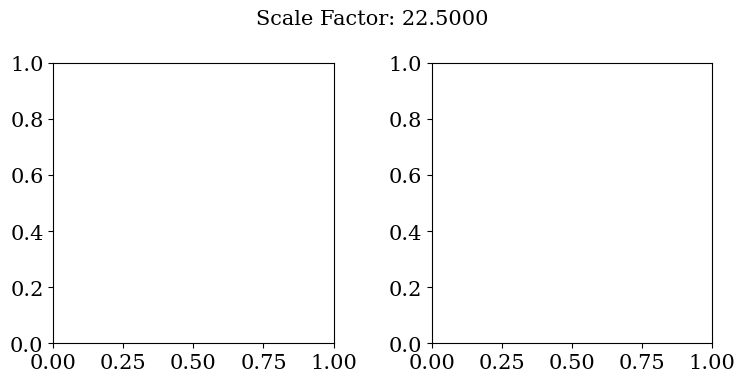

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation

# Build frame_data list from your data arrays
frame_data = []
for im in range(len(models)):
    q   = all_q[im]
    dx0 = all_dx0[im]
    for ia, va in enumerate(all_a[im]):
        frame_data.append({
            't': va,
            'q': q,
            'dx0': dx0,
            'z': all_ztrue[im][ia],
            'v': all_vtrue[im][ia],
            'znet': all_znet[im][ia].flatten(),
            'vnet': all_vnet[im][ia].flatten()
        })

# Create figure and axes
fig = plt.figure(figsize=(8.5, 4))
gs = gridspec.GridSpec(1, 2, hspace=0.25, wspace=0.35)
ax = np.array([[fig.add_subplot(gs[0, i]) for i in range(2)]])
for axi in ax.flat:
    axi.set_box_aspect(1)

# Suptitle text for scale factor
scale_factor_text = fig.suptitle("", fontsize=15, y=0.98)

# Init function
def init():
    for a in ax.flat:
        a.cla()
    return []

# Update function
def update(frame_idx):
    # Clear current frame
    for a in ax.flat:
        a.cla()
    
    # Set titles, labels, and limits
    ax[0,0].text(0.03, 0.9, "PIKAN", transform=ax[0,0].transAxes)
    ax[0,1].text(0.03, 0.9, "N-Body", transform=ax[0,1].transAxes)
    ax[0,0].set_xlabel("x")
    ax[0,1].set_xlabel("x")
    ax[0,0].set_ylabel("v")
    ax[0,0].set_xlim([-0.5, 0.5])
    ax[0,1].set_xlim([-0.5, 0.5])

    # Get data for this frame
    fd = frame_data[frame_idx]
    u_x = fd['znet'] + fd['q'] + fd['dx0']

    # Plot lines in black
    ax[0,0].plot(u_x, fd['vnet'], c='black', linewidth=1.0)
    ax[0,1].plot(fd['z'] + fd['q'], fd['v'], c='black', linewidth=1.0)

    # Update central scale factor label
    scale_factor_text.set_text(f"Scale Factor: {fd['t']:.4f}")

    return []

# Create animation
anim = FuncAnimation(
    fig, update, frames=len(frame_data),
    init_func=init, blit=False, interval=200  # 200 ms per frame (slower)
)

# Save as GIF
anim.save('../figures/pikan_and_nbody.gif', writer='pillow', fps=8)
